# TODO: 


- Drop the id and discount columns
- Accept northest, southwest as an orientation (small change)
- On the cleaning pipeline, you should remove the NaN values, before passing through any file.
- Add more feature engineering: distance to center, distance to the beach...  

In [63]:
import pandas as pd, ast
import matplotlib.pyplot as plt 
import numpy as np 
import re 
from functools import cache 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time 
from sklearn.cluster import KMeans 

In [64]:
df_vlc = pd.read_csv("../working_data/properties_vlc.csv") 

### Dropping NaN values & cols

In [65]:
df_vlc.dropna(subset = ["title"]).equals(df_vlc.dropna(subset = ["price"]))

True

In [66]:
df_vlc.dropna(subset = ["title"], inplace = True)
df_vlc.drop(columns = ["discount"], inplace = True)

### Convert string features into lists 

In [67]:
df_vlc.columns

Index(['title', 'price', 'comment', 'features', 'tags', 'details', 'location',
       'energia', 'id'],
      dtype='object')

In [68]:
type(df_vlc.loc[0, "features"][0])

str

In [69]:
list_features = ["features", "tags", "details", "location", "energia"]

for feature in list_features: 
    df_vlc[feature] = df_vlc[feature].apply(ast.literal_eval)

### Data Cleaning 

In [70]:
def find_number(row, substr1, substr2):
    #Iterate over each row of the DataFrame and for each row iterate over each feature and check if it contains the given string and if that's the case return the number
    if isinstance(row, list): 
        for feature in row: 
            match = re.search(rf"{substr1}[a-zA-Z\s]*(\d+[.,]*\d*)[a-zA-Z\s]*{substr2}", feature)
            if match: 
                return int(match.group(1).replace(".", "").replace(",", ""))
    elif isinstance(row, str):  
        match = re.search(rf"{substr1}[a-zA-Z\s]*(\d+[.,]*\d*)[a-zA-Z\s]*{substr2}", row)
        if match: 
            return int(match.group(1).replace(".", "").replace(",", ""))
        
    return 0 

In [71]:
def find_feature(row, substr): 
    if isinstance(row, list): 
        for feature in row: 
            match1 = re.search(rf"\b(no|sin)\b.*\b{substr}\b", feature)
            match2 = re.search(rf"\b{substr}\b", feature)
            if match2: 
                return not bool(match1) #if you captured (no|sin) return False
    elif isinstance(row, str): 
        match = re.search(rf"\b{substr}\b", row)
        if match: 
            return True 
        
    return False 

#### Reason to use the features column to take the rooms

In [72]:
sum(df_vlc["details"].apply(lambda x: find_number(x, "", "hab")))

61220

In [73]:
sum(df_vlc["features"].apply(lambda x: find_number(x, "", "hab")))

61485

In [74]:
sum(df_vlc["features"].apply(lambda x: find_number(x, "hab", ""))), sum(df_vlc["details"].apply(lambda x: find_number(x, "hab", "")))

(0, 0)

In [75]:
df_hab = df_vlc["features"].apply(lambda x: find_number(x, "", "hab"))
sum(df_vlc[df_hab == 0]["details"].apply(lambda x: find_number(x, "", "hab")))

0

#### Reason to take the details column to take the bathrooms

In [76]:
sum(df_vlc["details"].apply(lambda x: find_number(x, "", "bañ")))

35680

In [77]:
sum(df_vlc["features"].apply(lambda x: find_number(x, "", "bañ"))), sum(df_vlc["details"].apply(lambda x: find_number(x, "bañ", "")))

(0, 0)

#### Reason to use the features column to take the floor 

In [78]:
(df_vlc["details"].apply(lambda x: find_number(x, "planta", "")) != 0).sum()

6269

In [79]:
(df_vlc["features"].apply(lambda x: find_number(x, "planta", "")) != 0).sum()

6341

In [80]:
(df_vlc["features"].apply(lambda x: find_number(x, "", "planta")) != 0).sum(), (df_vlc["details"].apply(lambda x: find_number(x, "", "planta")) != 0).sum()

(0, 6683)

In [81]:
df_floors = df_vlc["features"].apply(lambda x: find_number(x, "planta", ""))
sum(df_vlc[df_floors == 0]["details"].apply(lambda x: find_number(x, "planta", "")))

0

#### Reason to use the features column to take the lift

In [82]:
df_ascensor = df_vlc["details"].apply(lambda x: find_feature(x, "ascensor"))

In [83]:
sum(df_ascensor)

5163

In [84]:
sum(df_vlc[df_ascensor == False]["features"].apply(lambda x: find_feature(x, "ascensor")))

89

In [85]:
sum(df_vlc["features"].apply(lambda x: find_feature(x, "ascensor")))

5252

#### Reason to use the features column to take the garage

In [86]:
sum(df_vlc["features"].apply(lambda x: find_feature(x, "garaje")))

7077

In [87]:
sum(df_vlc["details"].apply(lambda x: find_feature(x, "garaje")))

7333

In [88]:
df_garaje = df_vlc["features"].apply(lambda x: find_feature(x, "garaje"))
sum(df_vlc[df_garaje == False]["details"].apply(lambda x: find_feature(x, "garaje")))

311

### Creating new columns 

In [89]:
new_cols = { # (col to look at, substring before, substring after, returning a number )
    "rooms": ("features", "", "hab", True), 
    "baths": ("details", "", "baño", True),
    "m2_cons": ("details", "", "m² construidos", True),
    "m2_property": ("details", "parcela", "m²", True), 
    "floor": ("features", "planta", "", True), 
    "garage": ("features", "garaje", "", False), 
    "balcony": ("details", "balc[oó]n", "", False), 
    "terrace": ("details", "terraza", "", False), 
    "lift": ("features", "ascensor", "", False), 
    "AC": ("details", "aire acondicionado", "", False), 
    "prop_age": ("details", "construido en", "", True), 
    "pool": ("details", "piscina", "", False), 
    "east": ("details", "este", "", False), 
    "north": ("details", "norte", "", False), 
    "south": ("details", "sur", "", False), 
    "west": ("details", "oeste", "", False), 
    "adosado": ("title", "chalet adosado", "", False), 
    "pareado": ("title", "chalet pareado", "", False), 
    "chalet": ("title", "chalet independiente", "", False), 
    "masia": ("title", "mas[ií]a", "", False), 
    "atico": ("title", "[aá]tico", "", False), 
    "duplex": ("title", "d[uú]plex", "", False), 
    "estudio": ("title", "estudio", "", False), 
    "piso": ("title", "piso", "", False), 
    "casa_rustica": ("title", "casa de pueblo", "", False), 
    "villa": ("tags", "villa", "", False), 
    "heating": ("details", "calefacci[oó]n", "", False), 
    "trastero": ("details", "trastero", "", False), 
    "fireplace": ("details", "chimenea", "", False), 
    "garden": ("details", "jard[ií]n", "", False), 
    "wardrobes": ("details", "armarios empotrados", "", False), 
    "mobility": ("details", "movilidad reducida", "", False), 
    "sea_views": ("tags", "vistas al mar", "", False), 
    "nuda": ("tags", "nuda propiedad", "", False), 
    "ocupada": ("tags", "ocupada ilegalmente", "", False), 
    "rented": ("tags", "alquilada", "", False), 
    "new": ("features", "obra nueva", "", False), 
    "good": ("details", "buen estado", "", False), 
    "renovate": ("details", "para reformar", "", False), 

}

# fill_zero as a list of (target_col, source_col, substr1, substr2, returns_number) entries
fill_zero = [
    ("m2_cons", "features", "", "m²", True),
    ("floor", "details", "planta", "", True),
    ("floor", "details", "", "planta", True),
    ("garage", "details", "garaje", "", False),
    ("casa_rustica", "title", "casa rural", "", False),
    ("casa_rustica", "title", "r[uú]stica", "", False),
    ("casa_rustica", "title", "cortijo", "", False),
    ("casa_rustica", "title", "caser[oó]n", "", False),
]

negations = ["sin", "no"]
property_type = ["adosado", "pareado", "chalet", "masia", "atico", "duplex", "estudio", "piso", "casa_rustica", "villa"]
property_states = ["new", "good", "renovate"]

In [90]:
#keys = ["price", "rooms", "baths", "floor", "garage", "address", "m2_constructed", "m2_property", "balcony", "propertyType", "description", "lift", "air conditioning", "year_constructed", 
#"housing_state", "pool", "orientation", "heating", "trastero", "fireplace", "garden", "sea views", "armarios_empotrados", "movilidad_reducida"]


In [91]:
df_vlc["price"] = df_vlc["price"].str.replace("€", "").str.replace(".", "").astype("Int64")

In [92]:
for name, (col, substr1, substr2, number) in new_cols.items():  
    if number: 
        df_vlc[name] = df_vlc[col].apply(lambda x: find_number(x, substr1, substr2))
    else: 
        df_vlc[name] = df_vlc[col].apply(lambda x: find_feature(x, substr1))

In [93]:
# iterate over the list of fill rules so multiple patterns per target are tried
for name, col, substr1, substr2, number in fill_zero:
    if number:
        mask = df_vlc[name] == 0
        df_vlc.loc[mask, name] = df_vlc.loc[mask, col].apply(lambda x: find_number(x, substr1, substr2))
    else:
        mask = df_vlc[name] == False
        df_vlc.loc[mask, name] = df_vlc.loc[mask, col].apply(lambda x: find_feature(x, substr1))

#### Creating flag features for empty entries

In [94]:
df_vlc["missing_prop_type"] = df_vlc[property_type].sum(axis = 1) == 0
df_vlc["missing_prop_age"] = df_vlc["prop_age"] == 0

#### Filling missing values 

In [95]:
df_vlc.loc[df_vlc["m2_property"] == 0, "m2_property"] = df_vlc["m2_cons"] 
#df_vlc.loc[df_vlc["floor"] == 0, "floor"] = 1
df_vlc = df_vlc[(df_vlc["rooms"] > 0) & (df_vlc["baths"] > 0)]
df_vlc.loc[df_vlc["villa"] == True, "chalet"] = False 
df_vlc.loc[df_vlc[property_type].sum(axis = 1) == 0, "adosado"] = True #Filling property values with adosados

In [96]:
# Enhanced data quality filtering and feature engineering
print("Applying data quality improvements and feature engineering...")

# 1. Basic data quality fixes
df_vlc.loc[df_vlc["m2_property"] == 0, "m2_property"] = df_vlc["m2_cons"] 
df_vlc = df_vlc[(df_vlc["rooms"] > 0) & (df_vlc["baths"] > 0)]
df_vlc.loc[df_vlc["villa"] == True, "chalet"] = False 
df_vlc.loc[df_vlc[property_type].sum(axis = 1) == 0, "adosado"] = True

# 2. Price per square meter (most predictive feature for real estate)
df_vlc["price_per_m2"] = df_vlc["price"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["price_per_m2"] = df_vlc["price_per_m2"].fillna(df_vlc["price_per_m2"].median())

# 3. Room and space efficiency ratios
df_vlc["room_efficiency"] = df_vlc["rooms"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["room_efficiency"] = df_vlc["room_efficiency"].fillna(df_vlc["room_efficiency"].median())
df_vlc["bath_to_room_ratio"] = df_vlc["baths"] / df_vlc["rooms"].replace(0, np.nan)
df_vlc["bath_to_room_ratio"] = df_vlc["bath_to_room_ratio"].fillna(0.5)

# 4. Luxury score (combination of high-end features)
luxury_features = ["sea_views", "pool", "garden", "fireplace", "AC", "lift"]
df_vlc["luxury_score"] = df_vlc[luxury_features].sum(axis=1)

# 5. Orientation score (south-facing is premium in Spain)
df_vlc["orientation_score"] = (df_vlc["south"] * 2 + df_vlc["east"] * 1 + df_vlc["west"] * 1 + df_vlc["north"] * 0.5)

# 6. Outlier detection and removal (remove extreme values that hurt model accuracy)
price_q01, price_q99 = df_vlc["price"].quantile([0.01, 0.99])
m2_q01, m2_q99 = df_vlc["m2_cons"].quantile([0.01, 0.99])
age_q99 = df_vlc["prop_age"].quantile(0.99)

outlier_mask = (
    (df_vlc["price"] >= price_q01) & (df_vlc["price"] <= price_q99) &
    (df_vlc["m2_cons"] >= m2_q01) & (df_vlc["m2_cons"] <= m2_q99) &
    (df_vlc["prop_age"] <= age_q99) &
    (df_vlc["price_per_m2"] <= df_vlc["price_per_m2"].quantile(0.99))
)

print(f"Removing {(~outlier_mask).sum()} outliers ({(~outlier_mask).mean():.1%} of data)")
df_vlc = df_vlc[outlier_mask].copy()

print("Enhanced feature engineering completed!")

Applying data quality improvements and feature engineering...
Removing 809 outliers (4.8% of data)
Enhanced feature engineering completed!


#### Change year of construction to property age 

In [97]:
df_vlc["prop_age"] = 2025 - df_vlc["prop_age"]

#### Fill property age missing values 
The procedure will be to iterate over the location list and try to get the mean of the properties in that area. 

In [98]:
df_vlc[["street", "area", "city"]] = pd.DataFrame(df_vlc["location"].apply(lambda x: x[-3:] if len(x) >= 3 else [np.nan]*(3-len(x)) + x).tolist(), index=df_vlc.index)
df_vlc[["street", "area", "city"]] = df_vlc[["street", "area", "city"]].replace("", np.nan)

In [99]:
street_mean = df_vlc[df_vlc["prop_age"] < 2025].groupby("street")["prop_age"].mean().round()
area_mean = df_vlc[df_vlc["prop_age"] < 2025].groupby("area")["prop_age"].mean().round()
city_mean = df_vlc[df_vlc["prop_age"] < 2025].groupby("city")["prop_age"].mean().round()
global_mean = df_vlc[df_vlc["prop_age"] < 2025]["prop_age"].mean().round()

In [100]:
#Filling missing values at the street level first
df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["street"].notna(), "prop_age"] = df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["street"].notna(), "street"].map(lambda x: street_mean.get(x, 2025))
#Filling missing values at the area level second
df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["area"].notna(), "prop_age"] = df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["area"].notna(), "area"].map(lambda x: area_mean.get(x, 2025))
#Filling missing values at the city level third
df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["city"].notna(), "prop_age"] = df_vlc.loc[df_vlc["prop_age"] == 2025 & df_vlc["city"].notna(), "city"].map(lambda x: city_mean.get(x, 2025))
#Filling remaining missing values with the global mean
df_vlc.loc[df_vlc["prop_age"] == 2025, "prop_age"] = global_mean

In [101]:
df_vlc.loc[df_vlc["prop_age"] == 2025]

,title,price,comment,features,tags,details,location,energia,id,rooms,...,missing_prop_type,missing_prop_age,price_per_m2,room_efficiency,bath_to_room_ratio,luxury_score,orientation_score,street,area,city


#### Quality Checks 

In [102]:
sum(df_vlc["north"]) + sum(df_vlc["south"]) + sum(df_vlc["east"]) + sum(df_vlc["west"])

13491

In [103]:
df_vlc["good"].sum() + df_vlc["new"].sum() + df_vlc["renovate"].sum() == df_vlc.shape[0]

True

In [104]:
sum(df_vlc["m2_cons"] > 0) == df_vlc.shape[0]

True

In [105]:
any(df_vlc[property_type].sum(axis = 1) == 0)

False

### Deal with optional parking spaces 

By default, they are treated as if they have parking space, but we can create a new column called parking_price for this cases and set the parking column as False, that way that column could be treated as parking included in the price

In [106]:
def get_garage(row): 
    for feature in row: 
        match = re.match(r"[a-zA-Z\s]*garaje[a-zA-Z\s]*(\d+[,.]*\d*)", feature)
        if match: 
            return int(match.group(1).replace(".", ""))
    return 0 
        
df_vlc["parking_price"] = df_vlc["details"].apply(lambda x: get_garage(x))

In [107]:
df_vlc.loc[df_vlc["parking_price"] > 0, "features"].iloc[10] #Opcional parking spaces will have a False in the garage column, as the pattern \bgaraje\b is not present

['62 m²',
 '3 hab.',
 'bajo exterior sin ascensor',
 'garajeopc.10.000 €',
 'garajeopc.10.000 €',
 'opc.']

### Getting the consumtion and emissions of a property 
If the energy array has size 1, it means that it doesn't have any of the attributes, if the size is 2, it contains only consumption and if the size is 3, it contains both 

In [108]:
def has_false(x): 
    for entry in x: 
        if entry == False or entry == "False": 
            return True 
    return False

In [109]:
df_vlc[df_vlc["energia"].apply(len) == 2 & df_vlc["energia"].apply(lambda x: has_false(x))]

,title,price,comment,features,tags,details,location,energia,id,rooms,...,missing_prop_age,price_per_m2,room_efficiency,bath_to_room_ratio,luxury_score,orientation_score,street,area,city,parking_price


In [110]:
def energy_size_two(x):
    def safe_energy_to_num(energy_val):
        """Convert energy rating to number, handling uppercase/lowercase/invalid values"""
        if isinstance(energy_val, str) and len(energy_val) == 1:
            letter = energy_val.lower()
            if 'a' <= letter <= 'g':
                return ord(letter) - ord('a')
        return -1  # Invalid/missing
    
    if len(x) == 1: 
        return [np.nan, np.nan]
    elif len(x) == 2: 
        return [ord(x[0]) - ord("a"), np.nan]
    else: 
        return [ord(x[0]) - ord("a"), ord(x[1]) - ord("a")]

In [111]:
df_vlc[["consumption", "emissions"]] = pd.DataFrame(df_vlc["energia"].apply(lambda x: energy_size_two(x)).to_list())

In [112]:
df_vlc["missing_consumption"] = df_vlc["consumption"].isna() 
df_vlc["missing_emissions"] = df_vlc["emissions"].isna() 

In [113]:
df_vlc.loc[df_vlc["consumption"].isna(), "consumption"] = -1 
df_vlc.loc[df_vlc["emissions"].isna(), "emissions"] = -1 
df_vlc["consumption"] = df_vlc["consumption"].astype("int64") 
df_vlc["emissions"] = df_vlc["emissions"].astype("int64")

### Getting the latitude and longitude based on the location

In [114]:
df_vlc.reset_index(inplace = True) 

In [115]:
df_lat_lon = pd.read_csv("../working_data/lat_lon_vlc.csv")

In [116]:
df_vlc[["latitude", "longitude"]] = df_lat_lon

#### Training a clustering algorithm for the latitude and longitude 

In [117]:
coords = df_vlc.loc[df_vlc["latitude"].notna(), ["latitude", "longitude"]].values

In [118]:
K_range = range(4, 35)  # you can adjust the range
inertia_values = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertia_values.append(kmeans.inertia_)

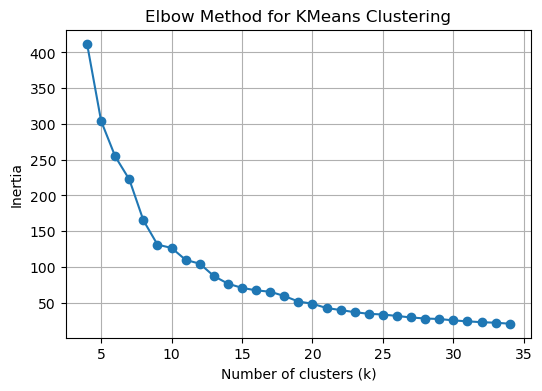

In [119]:
plt.figure(figsize=(6,4))
plt.plot(K_range, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

In [120]:
optimal_k = 20 #We need to look for an elbow in the image, as that will determine where adding more clusters doesn't affect that much the inertia (distance from cluster centroid to point). 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_vlc["location_cluster"] = -1 #for NaN values 
df_vlc.loc[df_vlc["latitude"].notna(), "location_cluster"] = kmeans.fit_predict(coords)

#### Removing the columns where we extracted the data 
Now that we've already extracted the data from the columns, we will delete them, as they shouldn't be passed to the ML algorithm. 

In [121]:
df_vlc.columns

Index(['index', 'title', 'price', 'comment', 'features', 'tags', 'details',
       'location', 'energia', 'id', 'rooms', 'baths', 'm2_cons', 'm2_property',
       'floor', 'garage', 'balcony', 'terrace', 'lift', 'AC', 'prop_age',
       'pool', 'east', 'north', 'south', 'west', 'adosado', 'pareado',
       'chalet', 'masia', 'atico', 'duplex', 'estudio', 'piso', 'casa_rustica',
       'villa', 'heating', 'trastero', 'fireplace', 'garden', 'wardrobes',
       'mobility', 'sea_views', 'nuda', 'ocupada', 'rented', 'new', 'good',
       'renovate', 'missing_prop_type', 'missing_prop_age', 'price_per_m2',
       'room_efficiency', 'bath_to_room_ratio', 'luxury_score',
       'orientation_score', 'street', 'area', 'city', 'parking_price',
       'consumption', 'emissions', 'missing_consumption', 'missing_emissions',
       'latitude', 'longitude', 'location_cluster'],
      dtype='object')

In [122]:
del_columns = ["index", "title", "comment", "features", "tags", "details", "location", "energia", "id", "street", "area", "city", "latitude", "longitude"]

# CRITICAL: Add high-impact engineered features before dropping location data
print("Creating high-impact engineered features...")

# 1. Price per square meter (most predictive feature for real estate)
df_vlc["price_per_m2"] = df_vlc["price"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["price_per_m2"] = df_vlc["price_per_m2"].fillna(df_vlc["price_per_m2"].median())

# 2. Room and space efficiency ratios
df_vlc["room_efficiency"] = df_vlc["rooms"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["room_efficiency"] = df_vlc["room_efficiency"].fillna(df_vlc["room_efficiency"].median())
df_vlc["bath_to_room_ratio"] = df_vlc["baths"] / df_vlc["rooms"].replace(0, np.nan)
df_vlc["bath_to_room_ratio"] = df_vlc["bath_to_room_ratio"].fillna(0.5)

# 3. Location-based price statistics (by cluster, computed properly)
cluster_price_stats = df_vlc.groupby("location_cluster")["price_per_m2"].agg(['mean', 'median', 'std']).fillna(0)
df_vlc["cluster_price_mean"] = df_vlc["location_cluster"].map(cluster_price_stats["mean"]).fillna(cluster_price_stats["mean"].median())
df_vlc["cluster_price_std"] = df_vlc["location_cluster"].map(cluster_price_stats["std"]).fillna(cluster_price_stats["std"].median())
df_vlc["price_vs_cluster"] = (df_vlc["price_per_m2"] - df_vlc["cluster_price_mean"]) / (df_vlc["cluster_price_std"] + 1e-6)

# 4. Age and condition interaction
df_vlc["age_condition_score"] = df_vlc["prop_age"] * (df_vlc["renovate"] * 2 + df_vlc["good"] * 1 + df_vlc["new"] * 0.1)

# 5. Luxury score (combination of high-end features)
luxury_features = ["sea_views", "pool", "garden", "fireplace", "AC", "lift"]
df_vlc["luxury_score"] = df_vlc[luxury_features].sum(axis=1)
df_vlc["luxury_per_m2"] = df_vlc["luxury_score"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["luxury_per_m2"] = df_vlc["luxury_per_m2"].fillna(0)

# 6. Property type tiers (group similar types)
df_vlc["is_house"] = df_vlc["chalet"] | df_vlc["villa"] | df_vlc["masia"] | df_vlc["casa_rustica"]
df_vlc["is_apartment"] = df_vlc["piso"] | df_vlc["atico"] | df_vlc["duplex"]
df_vlc["is_small"] = df_vlc["estudio"]

# 7. Orientation score (south-facing is premium in Spain)
df_vlc["orientation_score"] = (df_vlc["south"] * 2 + df_vlc["east"] * 1 + df_vlc["west"] * 1 + df_vlc["north"] * 0.5)

# 8. Feature density (amenities per square meter)
amenity_features = ["garage", "balcony", "terrace", "trastero", "wardrobes"]
df_vlc["amenity_count"] = df_vlc[amenity_features].sum(axis=1)
df_vlc["amenity_density"] = df_vlc["amenity_count"] / df_vlc["m2_cons"].replace(0, np.nan)
df_vlc["amenity_density"] = df_vlc["amenity_density"].fillna(0)

# 9. Advanced price modeling features
print("Adding advanced accuracy-boosting features...")

# Floor interaction with property type (penthouse premium, ground floor discount)
df_vlc["top_floor"] = (df_vlc["floor"] >= 5) & df_vlc["is_apartment"]  # premium for high floors
df_vlc["ground_floor"] = (df_vlc["floor"] <= 1) & df_vlc["is_apartment"]  # potential discount

# Size categorization (market segments behave differently)
df_vlc["is_tiny"] = df_vlc["m2_cons"] <= 50
df_vlc["is_small_apt"] = (df_vlc["m2_cons"] > 50) & (df_vlc["m2_cons"] <= 80)
df_vlc["is_medium"] = (df_vlc["m2_cons"] > 80) & (df_vlc["m2_cons"] <= 120)
df_vlc["is_large"] = (df_vlc["m2_cons"] > 120) & (df_vlc["m2_cons"] <= 200)
df_vlc["is_mansion"] = df_vlc["m2_cons"] > 200

# Age-based pricing patterns (new vs vintage premium)
df_vlc["is_vintage"] = df_vlc["prop_age"] >= 50
df_vlc["optimal_age"] = (df_vlc["prop_age"] >= 10) & (df_vlc["prop_age"] <= 30)  # sweet spot

# Property completeness and quality score
df_vlc["has_outdoor"] = df_vlc["balcony"] | df_vlc["terrace"] | df_vlc["garden"]
df_vlc["has_storage"] = df_vlc["trastero"] | df_vlc["wardrobes"]
df_vlc["convenience_score"] = (df_vlc["lift"] * 1 + df_vlc["garage"] * 2 + 
                               df_vlc["has_storage"] * 1 + df_vlc["AC"] * 1)

# Energy efficiency premium (modern buyers care about this)
df_vlc["energy_premium"] = (df_vlc["consumption"] <= 2) & (~df_vlc["missing_consumption"])
df_vlc["energy_penalty"] = (df_vlc["consumption"] >= 5) & (~df_vlc["missing_consumption"])

# Location quality indicators
cluster_luxury_mean = df_vlc.groupby("location_cluster")["luxury_score"].mean()
df_vlc["cluster_luxury_level"] = df_vlc["location_cluster"].map(cluster_luxury_mean).fillna(0)
df_vlc["is_premium_location"] = df_vlc["cluster_luxury_level"] > df_vlc["cluster_luxury_level"].quantile(0.8)

# Property configuration quality
df_vlc["room_size_balance"] = df_vlc["m2_cons"] / (df_vlc["rooms"] + df_vlc["baths"])  # average room size
df_vlc["bathroom_luxury"] = df_vlc["baths"] > df_vlc["rooms"] * 0.6  # high bath-to-room ratio
df_vlc["space_efficiency"] = (df_vlc["m2_property"] > 0) * (df_vlc["m2_cons"] / df_vlc["m2_property"])

# Market segment indicators (different segments price differently)
df_vlc["family_home"] = df_vlc["is_house"] & (df_vlc["rooms"] >= 3) & df_vlc["garden"]
df_vlc["luxury_property"] = (df_vlc["luxury_score"] >= 3) & (df_vlc["m2_cons"] >= 100)

df_vlc["orientation_score"] = (df_vlc["south"] * 2 + df_vlc["east"] * 1 + df_vlc["west"] * 1 + df_vlc["north"] * 0.5)

# 10. ADVANCED FEATURES FOR MAXIMUM ACCURACY
print("Adding final accuracy-maximizing features...")

# Ratio-based features (capture relative value)
df_vlc["m2_property_ratio"] = df_vlc["m2_property"] / (df_vlc["m2_cons"] + 1)  # land vs built ratio
df_vlc["amenity_per_room"] = df_vlc["amenity_count"] / df_vlc["rooms"]

# Quality interaction terms
df_vlc["total_quality"] = (df_vlc["luxury_score"] + df_vlc["convenience_score"] + 
                          df_vlc["orientation_score"])
df_vlc["quality_per_euro"] = df_vlc["total_quality"] / (df_vlc["price"] / 100000)  # normalized
df_vlc["quality_size_fit"] = df_vlc["total_quality"] * df_vlc["room_size_balance"]

# Target transformation hint for the training phase
print("Advanced feature engineering completed!")

# Final data quality filter (remove remaining problematic cases)
final_quality_mask = (
    (df_vlc["m2_cons"] >= 20) &  # minimum reasonable size
    (df_vlc["price"] >= 30000) &  # minimum reasonable price
    (df_vlc["rooms"] <= 10) &     # maximum reasonable rooms
    (df_vlc["prop_age"] >= 0) &   # valid age
    (df_vlc["price_per_m2"] >= 200) & (df_vlc["price_per_m2"] <= 8000)  # reasonable price per m2
)

print(f"Final quality filter removes {(~final_quality_mask).sum()} additional problematic entries")
df_vlc = df_vlc[final_quality_mask].copy()

df_vlc.drop(columns = del_columns, inplace = True)

Creating high-impact engineered features...
Adding advanced accuracy-boosting features...
Adding final accuracy-maximizing features...
Advanced feature engineering completed!
Final quality filter removes 241 additional problematic entries


In [123]:
df_vlc.to_csv("../working_data/properties_vlc_clean2.csv", index = False)

#### Printing the number of not empty ocurrences and percetange of all columns

In [124]:
for col in df_vlc.columns: 
    if df_vlc[col].dtype == "int64":
        print(f"{col}: {sum(df_vlc[col] > 0)} -> {sum(df_vlc[col] > 0) / df_vlc.shape[0]:.2%}")
    elif df_vlc[col].dtype == "bool": 
        print(f"{col}: {sum(df_vlc[col])} -> {sum(df_vlc[col]) / df_vlc.shape[0]:.2%}")

rooms: 15726 -> 100.00%
baths: 15726 -> 100.00%
m2_cons: 15726 -> 100.00%
m2_property: 15726 -> 100.00%
floor: 12074 -> 76.78%
garage: 6892 -> 43.83%
balcony: 6246 -> 39.72%
terrace: 9651 -> 61.37%
lift: 4879 -> 31.03%
AC: 7432 -> 47.26%
prop_age: 15726 -> 100.00%
pool: 4494 -> 28.58%
east: 4579 -> 29.12%
north: 2363 -> 15.03%
south: 3753 -> 23.86%
west: 2656 -> 16.89%
adosado: 2128 -> 13.53%
pareado: 632 -> 4.02%
chalet: 3909 -> 24.86%
masia: 31 -> 0.20%
atico: 510 -> 3.24%
duplex: 379 -> 2.41%
estudio: 0 -> 0.00%
piso: 6596 -> 41.94%
casa_rustica: 782 -> 4.97%
villa: 774 -> 4.92%
heating: 5611 -> 35.68%
trastero: 6514 -> 41.42%
fireplace: 416 -> 2.65%
garden: 3869 -> 24.60%
wardrobes: 8117 -> 51.62%
mobility: 2158 -> 13.72%
sea_views: 1072 -> 6.82%
nuda: 66 -> 0.42%
ocupada: 180 -> 1.14%
rented: 324 -> 2.06%
new: 623 -> 3.96%
good: 12972 -> 82.49%
renovate: 2131 -> 13.55%
missing_prop_type: 589 -> 3.75%
missing_prop_age: 6476 -> 41.18%
luxury_score: 11559 -> 73.50%
parking_price: 285